# ДЗ №3
### *виконала студентка групи ФБ-33 Журавльова Марія* ###

Нагадаю, що мій набір даних - TMDB 10000 Movies Dataset (https://www.kaggle.com/datasets/i0xc0d3x00000/tmdb-10000-movies-dataset)

**Опис колонок:**

- title - назва фільму;
- overview - опис сюжету фільму;
- release_date - оригінальна дата випуску;
- vote_average - середній рейтинг фільму;
- vote_count - кількість отриманих голосів;
- original_language - мова зйомки;
- popularity - індекс популярності.



- **Вибрати з дз 2 два кластера з найбільшою кількістю елементів.**

Для цьго повторю кластерізацію K-means з Дз №2, щоб виділити 2 найбільші кластери та продовжити з ними працювати.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# завантажую дані
df = pd.read_csv(r"C:\Users\User\OneDrive\Desktop\university\МТАД\movie_tmdb_clean.csv")
x = df[['vote_average', 'vote_count']]

# маштабування (стандартизація даних)
scaler = StandardScaler()
scaled_x = scaler.fit_transform(x)

# k=3
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(scaled_x)

df_clusters = x.copy()
df_clusters['clusters'] = clusters

# центри кластерів
centers = scaler.inverse_transform(kmeans.cluster_centers_)
df_centers = pd.DataFrame(centers, columns=['vote_average', 'vote_count'])
df_centers.index.name = 'clusters'

# кількість елементів у кожному кластері
counts_kmean = df_clusters['clusters'].value_counts().sort_index()
df_centers['count'] = counts_kmean.values

print("Таблиця з цетрами кластерів та кількістю елементів:\n")
print(df_centers)

Таблиця з цетрами кластерів та кількістю елементів:

          vote_average   vote_count  count
clusters                                  
0             6.763735  2212.992006   1378
1             6.165047   532.318410   4177
2             7.291039   565.780775   3223


Отже, кластер 1 та 2 має найбільшу кількість елементів. Фільтрую дані лише по цих кластерах:

In [2]:
subset = df_clusters[df_clusters['clusters'].isin([1, 2])].copy()

# нова мітка для SVM (1->0, 2->1)
subset['label'] = subset['clusters'].map({1:0, 2:1})

X = subset[['vote_average', 'vote_count']]
Y = subset['label']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

- **Класифікувати методом опорних векторів.**

Використовую ***лінійне ядро***, оскільки це найпростіше ядро, яке шукає лінійну пряму розділяючу гіперплощину, а у мене лише 2 ознаки, які дадуть пряму лінію.

In [3]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# розділення на набори train та test
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.3, random_state=100)

# створення SVM з лінійним ядром
svm_model = SVC(kernel='linear', random_state=100)
svm_model.fit(X_train, Y_train)

# перевірка точності
Y_pred = svm_model.predict(X_test)
acc = accuracy_score(Y_test, Y_pred)
print(f"Точність класифікації: ", acc)

Точність класифікації:  1.0


Отже, ***точність класифікації складає 100%***, що свідчить про те, що кластери, які я обрала, дуже добре відокремлені у просторі ознак.

- **Намалювати класи та розділяючу гіперлощину.**

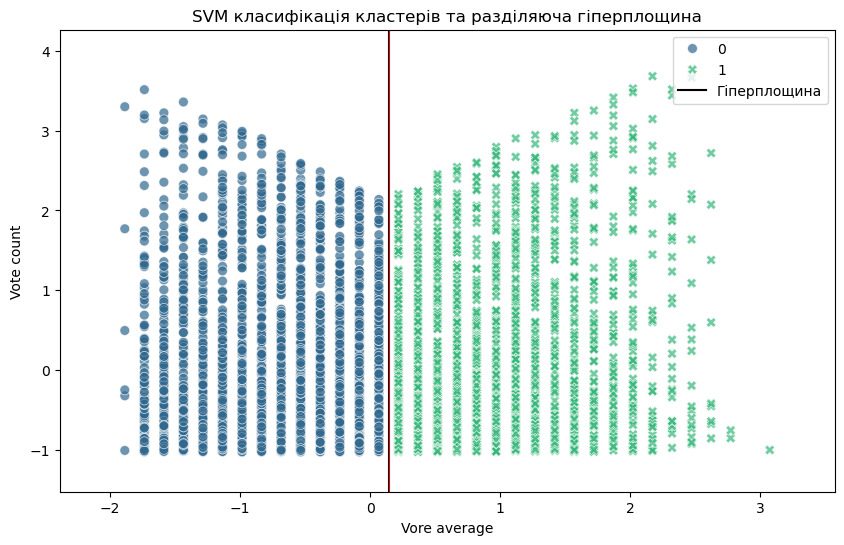

In [4]:
import seaborn as sns
import numpy as np

plt.figure(figsize=(10,6))
sns.scatterplot(x=X_train[:, 0], y=X_train[:, 1],
                hue=Y_train, palette='viridis', style=Y_train, 
                s=50, alpha=0.7)

# розрахунок розділяючої гіперплощини (w*x + b = 0)
w = svm_model.coef_[0]
b = svm_model.intercept_[0]

# межі осей для побудови лінії
x_min = X_train[:, 0].min() - 0.5
x_max = X_train[:, 0].max() + 0.5
y_min = X_train[:, 1].min() - 0.5
y_max = X_train[:, 1].max() + 0.5

# y = -(w[0]/w[1]) * x - (b/w[1]) (рівняння гіперплощини)
x_line = np.linspace(x_min, x_max, 100)
y_hyperplane = -(w[0] / w[1]) * x_line - (b / w[1])

# основна розділяюча лінія
plt.plot(x_line, y_hyperplane, color='black', label='Гіперплощина')

# відстань до опорних векторів
margin  = 1 / np.linalg.norm(w)

# паралельні лінії, що відображають межі допуску
y_margin_plus = y_hyperplane + margin
y_margin_minus = y_hyperplane - margin

plt.plot(x_line, y_margin_plus, color='red', linewidth=0.5)
plt.plot(x_line, y_margin_minus, color='red', linewidth=0.5)

plt.title('SVM класифікація кластерів та разділяюча гіперплощина')
plt.xlabel('Vore average')
plt.ylabel('Vote count')
plt.legend()
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.show()

**Висновок:** на графіку видно розділяючу гіперплощину (пряму лінію), яка ідеально розділяє два класи. Розділяюча лінія перпендикулярна до осі Vote average, що підкреслює, що середній рейтинг фільму є головною ознакою, яка визначає приналежність фільму до одного з кластерів. Червоні лінії (margin), які відображають відстань до опорних векторів, рощсташовані дуже близько до гіперплощини, що свідчить про відсутність "конфліктних" даних та чітку відокремленість класів.